In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from evaluation import *

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-09 18:13:15.835275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 18:13:16.038648: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-09 18:13:16.089677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 18:13:18.019344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #3
Using GPU #3


## 1. Preparing Dataset

## 2. Loading Dataset

In [2]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
rna = rna[:,rna.var.highly_variable]
prot = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}
    
cell_type_list1=['CD4+ naïve T','CD4+ memory T','intermediate mono','CD8+ memory T','CD14 mono',
                   'NK','intermediate mono','mature B','pre-B','memory-like NK','intermediate mono', 
                   'CD16 mono','Treg','CD8+ naïve T','pDC']
cell_type_list_modified1=cell_type_list1
rank_genes_groups=rna.uns["rank_genes_groups"]["names"]

cell_type_list2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
               'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
rank_prots_groups=prot.uns["rank_genes_groups"]["names"]
cell_type_list_modified2=['CD4+ naïve T', 'CD4+ memory T', 'Treg','CD8+ naïve T','CD8+ memory T','NK','memory-like NK',
                 'pre-B','mature B', 'CD14 mono','intermediate mono','CD16 mono','pDC']
        

In [3]:
rna

View of AnnData object with n_obs × n_vars = 3891 × 1734
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
prot

AnnData object with n_obs × n_vars = 3891 × 32
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

prot_Normalized_2000 = (prot.X-np.mean(prot.X,0))/np.std(prot.X,0)

In [6]:
[cells,genes] = RNA_Normalized_2000.shape

In [7]:
np.random.seed(11111986)
[I,J] = RNA_Normalized_2000.shape
[I,K] = prot_Normalized_2000.shape

In [8]:
[i,j] = np.nonzero(RNA_Normalized_2000)
X_tr1 = []
for cnt in range(len(i)):
    X_tr1.append([i[cnt],j[cnt]])
X_tr1 = np.asarray(X_tr1)
Y_tr1 = RNA_Normalized_2000.ravel()
 

In [9]:
[i,j] = np.nonzero(prot_Normalized_2000)
X_tr2 = []
for cnt in range(len(i)):
    X_tr2.append([i[cnt],j[cnt]])
X_tr2 = np.asarray(X_tr2)
Y_tr2 = prot_Normalized_2000.ravel()
 

## 3. Defining the model

## 4. Evaluation

In [10]:
C1 = np.array([None] * J)
n_marker_genes = 100
for i in range(len(cell_type_list_modified1)):
    if cell_type_list_modified1[i] not in {'ignore'}:
        for j in range(n_marker_genes):
            C1[np.where(rna.var_names.values==rank_genes_groups[j][i])]=(cell_type_list_modified1[i])

## 4.1 RNA analysis (Global Representation)

In [29]:
for filename in glob.glob('./Results/global.csv'):
    os.remove(filename)
os.makedirs("./Results", exist_ok=True)
filehandler = open("./Results/global.csv","wb")
dim_arr=[2, 4, 8, 16, 32]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 100000, 50000, 30000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]

for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':None,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
                                    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
                                    #sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, use_rep='X')
                                    sc.tl.umap(RNA_struct_MOGP, alpha=0.3, min_dist=.5)
                                    
                                    Acc_cells_arr=[]
                                    ARI_cells_arr=[]
                                    for cnt in range (10):
                                        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                        clusterer.fit(RNA_struct_MOGP.obsm['X_umap'])
                                        cluster_labels = clusterer.predict(RNA_struct_MOGP.obsm['X_umap'])
                                        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
                                        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
                                        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
                                
                                    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
                                    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
                                    sc.pp.neighbors(Genes_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.tl.umap(Genes_struct_MOGP, alpha=0.3, min_dist=.5)
                                    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
                                    Acc_genes_arr=[]
                                    ARI_genes_arr=[]
                                    for cnt in range (10):
                                        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                        clusterer.fit(Genes_struct_MOGP.obsm['X_umap'])
                                        cluster_labels_genes = clusterer.predict(Genes_struct_MOGP.obsm['X_umap'])
                                        train_labels_genes = np.array([col_dict1[i] for i in C1])
                                        Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
                                        ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
                                    
                                    pickle.dump(title,filehandler)
                                    pickle.dump(np.mean(Acc_cells_arr),filehandler)
                                    pickle.dump(np.mean(ARI_cells_arr),filehandler)
                                    pickle.dump(np.mean(Acc_genes_arr),filehandler)
                                    pickle.dump(np.mean(ARI_genes_arr),filehandler)
                                    
                                    
filehandler.close()      

2024-02-01 19:41:38.168979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 19:41:38.840546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13950 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated clas

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f807c049dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8178093dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3b8b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3b8b0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8266f3bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe8383790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe8383790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe0363d30>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe8383790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8243507f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe833f9d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8235615310>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8235615310>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe833f9d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fe833f9d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f700653a0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f6035a790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fb81b95e0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333ca0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fb811bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7fb811bee0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7eac321d30>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333160>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f6035a790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333430>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333430>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7a503ab670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7f60333430>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

/tmp/ipykernel_2249799/590018540.py:224: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  likelihood_container = gpflux.layers.TrackableLayer()
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7e9c29bdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7e9c29bdc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f79d01de670>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7a503ab790>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

2024-06-09 18:13:39.746575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 18:13:40.458708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14778 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:af:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/la

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.5366229760986891     ARI_cells:0.2178626016003747
Acc_genes:0.758073817762399     ARI_cells:0.38873676821511516


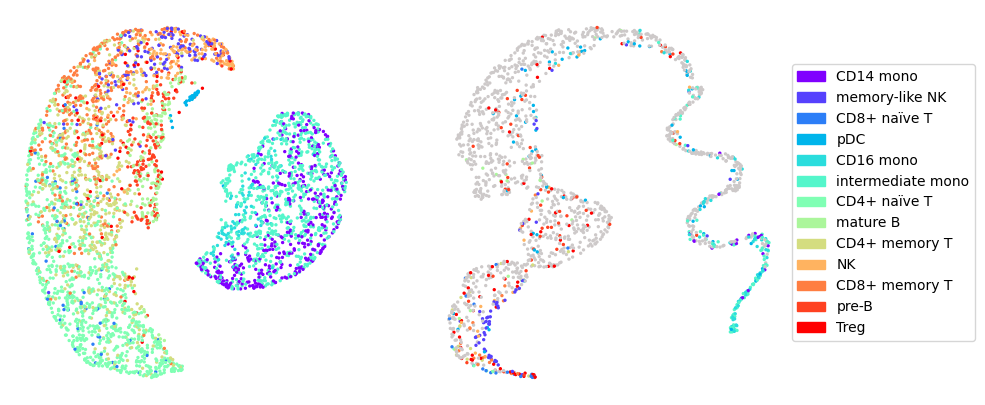

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7591621691081983     ARI_cells:0.4834296982725411
Acc_genes:0.7617070357554787     ARI_cells:0.30242859220609797


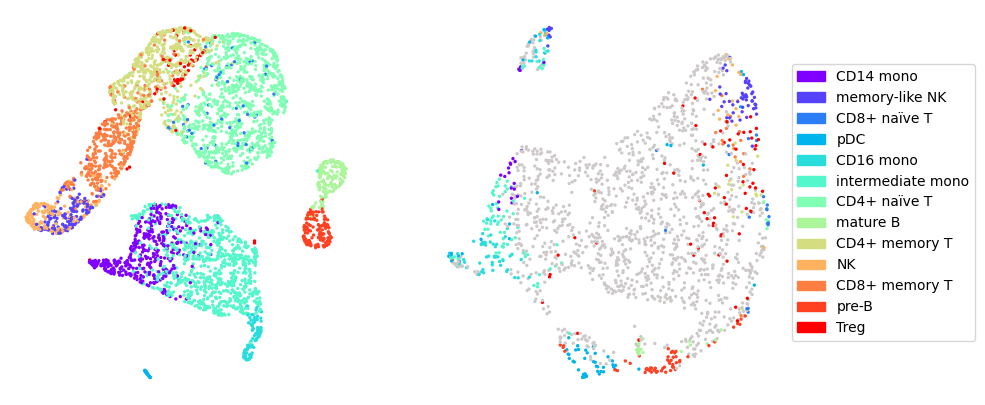

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=8` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.6924955024415318     ARI_cells:0.36012571346738576
Acc_genes:0.7746828143021914     ARI_cells:0.2546130138864149


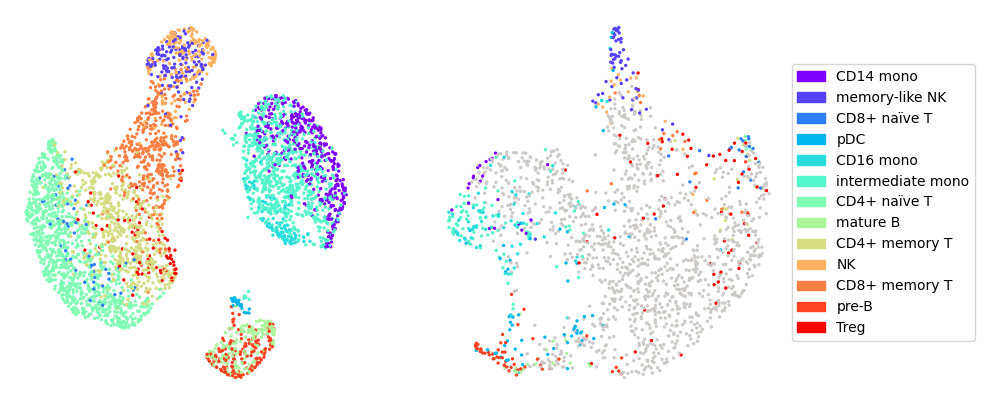

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=8` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7702647134412748     ARI_cells:0.468966176025139
Acc_genes:0.7457900807381777     ARI_cells:0.0


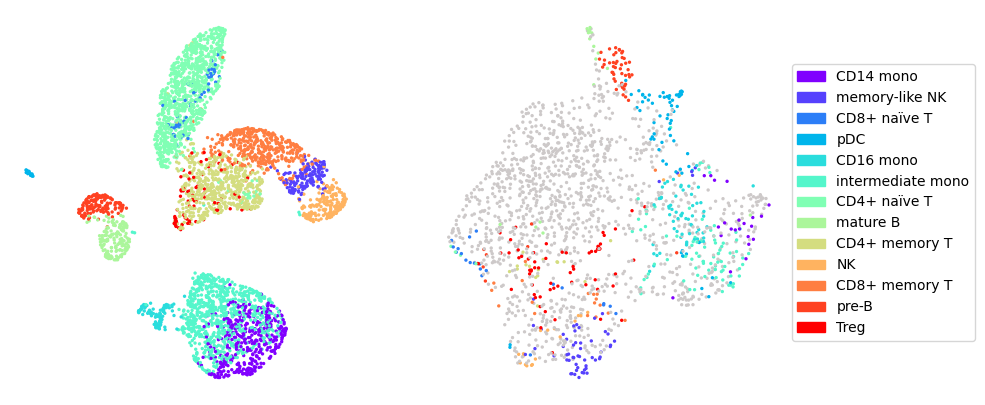

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=16` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=50000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.7824980724749422     ARI_cells:0.5332942357838095
Acc_genes:0.7528258362168397     ARI_cells:0.24522098048697324


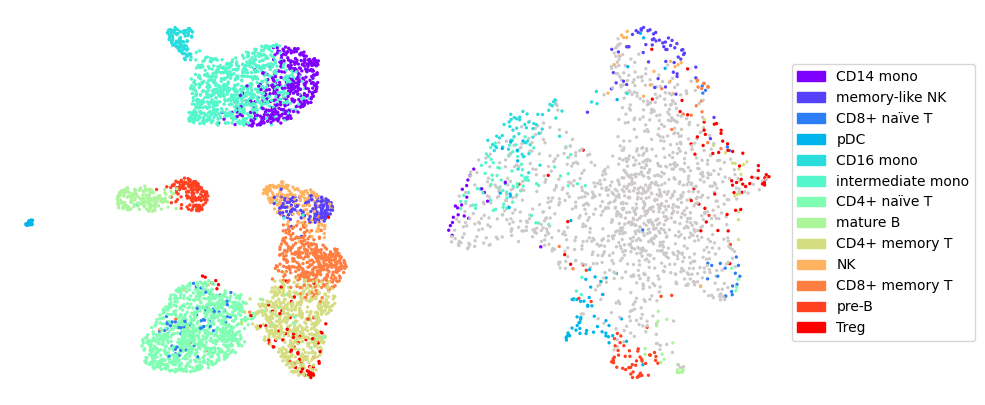

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=16` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=50000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7955795425340529     ARI_cells:0.5216683078362655
Acc_genes:0.7529411764705882     ARI_cells:0.062477174585704766


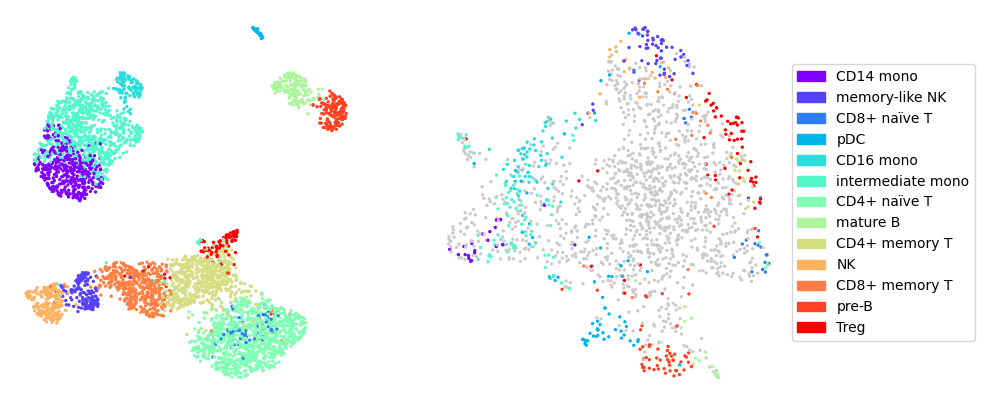

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=32` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=16  dim2=16  dim3=16  InducingPoints1=512  InducingPoints2=512  BatchSize=30000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.8311231046003597     ARI_cells:0.6175163488969594
Acc_genes:0.7379469434832757     ARI_cells:0.05633707988342387


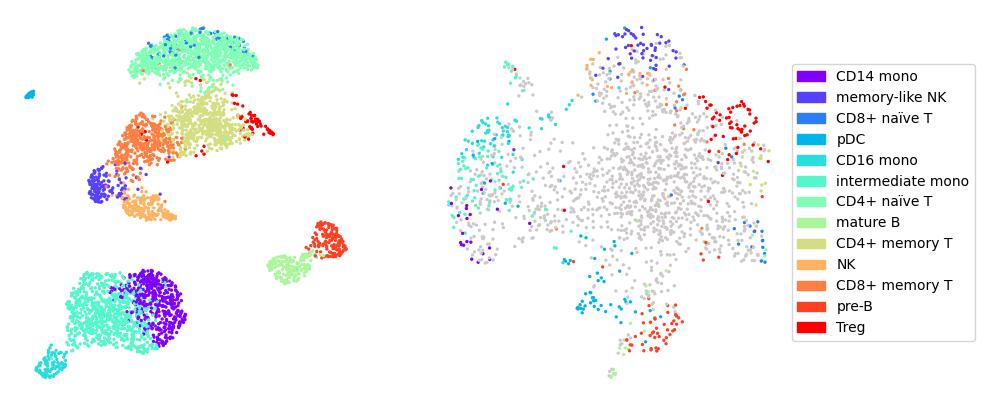

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=32` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=16  dim2=16  dim3=16  InducingPoints1=512  InducingPoints2=512  BatchSize=30000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.814520688768954     ARI_cells:0.5682878160382512
Acc_genes:0.7472318339100346     ARI_cells:0.15339287182753564


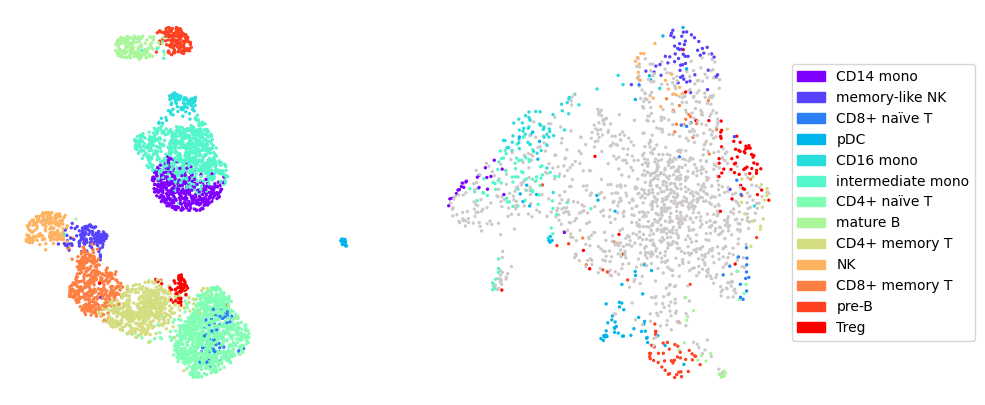

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=64` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=32  dim2=32  dim3=32  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=100  emb_reg=0.001 with_PCA=0
Acc_cells:0.8202775636083268     ARI_cells:0.5689813375353022
Acc_genes:0.7534602076124568     ARI_cells:0.21785381054358752


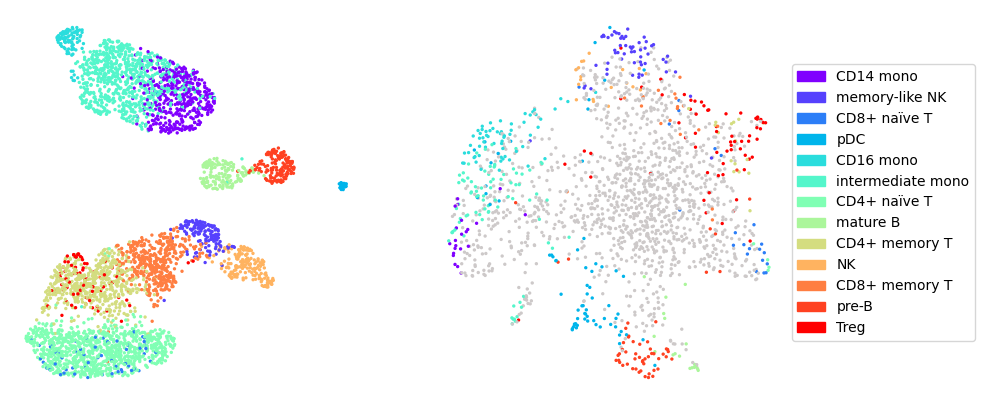

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=64` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(


dim1=32  dim2=32  dim3=32  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0
Acc_cells:0.7951940375224877     ARI_cells:0.5117781309285728
Acc_genes:0.7510380622837369     ARI_cells:0.14663050283223644


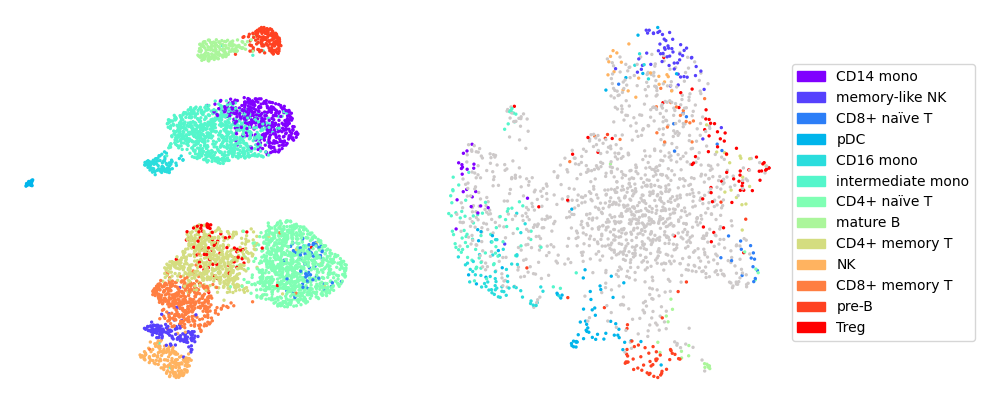

In [11]:
file = open("./Results/global.csv","rb")
dim_arr=[2, 4, 8, 16, 32]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 100000, 50000, 30000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]
for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':None,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
                                    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
                                    #sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, use_rep='X')
                                    sc.tl.umap(RNA_struct_MOGP, alpha=0.3, min_dist=.5)
                                    
                                    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
                                    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
                                    sc.pp.neighbors(Genes_struct_MOGP, n_neighbors=30, n_pcs=8)
                                    sc.tl.umap(Genes_struct_MOGP, alpha=0.3, min_dist=.5)
                                    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
                                    
                                    #Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=False)
                                    a1 = pickle.load(file)
                                    a2 = pickle.load(file)
                                    a3 = pickle.load(file)
                                    a4 = pickle.load(file)
                                    a5 = pickle.load(file)
                                    
                                    print(str(a1))
                                    print("Acc_cells:"+str(a2)+"     ARI_cells:"+str(a3))
                                    print("Acc_genes:"+str(a4)+"     ARI_cells:"+str(a5))
                                    Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(rna, prot, RNA_struct_MOGP, Genes_struct_MOGP, Prot_struct_MOGP=None, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=True)
                                    
file.close()        

## 4.2 RNA  analysis (Local Representation)

In [ ]:
for filename in glob.glob('./Results/local.csv'):
    os.remove(filename)
os.makedirs("./Results", exist_ok=True)
filehandler = open("./Results/local.csv","wb")
dim_arr=[2, 4, 8, 16, 32]
num_epochs_arr=[100, 500]
n_inducing_points_arr=[512]
batch_size_arr=[100000, 100000, 50000, 30000, 10000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]

for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                dim1 = dim_arr[l]
                                dim2 = dim_arr[l]
                                dim3 = dim_arr[l]
                                num_epochs = num_epochs_arr[m]
                                n_inducing_points1 = n_inducing_points_arr[n]
                                n_inducing_points2 = n_inducing_points_arr[n]
                                batch_size = batch_size_arr[l]
                                with_PCA=with_PCA_arr[p]
                                with_PPCA=with_PPCA_arr[q]
                                scale_emb1=scale_emb1_arr[r]
                                scale_emb2=scale_emb2_arr[s]
                                emb_reg=emb_reg_arr[t]
                                if (with_PCA==0 or with_PPCA==0):
                                    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
                                    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
                                    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
                                    hyper_params = {
                                    'I':I,
                                    'J':J,
                                    'K':None,    # the number of entities in each domain
                                    'M1': n_inducing_points1,                  # the number of inducing pairs
                                    'M2': n_inducing_points2,                  # the number of inducing pairs
                                    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
                                    'batch_size':batch_size,      # the size of training batches
                                    'obs_mean1': Y_tr1.mean(),  # the mean of target
                                    'obs_mean2': Y_tr2.mean(),  # the mean of target
                                    'emb_reg': emb_reg,          # l2 norm on the embeddings
                                    'lr': lr,                # the learning rate 
                                    'save_path': save_path,        # path to save the trained models.
                                    }  
                                    
                                    gp_md = GPD(**hyper_params)
                                    gp_md.build(kernels=kernel)
                                    gp_md.load_model((X_tr1+1), (X_tr2+1))
                                    
                                    emb1 = gp_md.emb1
                                    embs1 = emb1((X_tr1+1)[0:-1:J,0])
                                    
                                    emb2 = gp_md.emb2
                                    embs2 = emb2((X_tr1+1)[0:J,1])
                                    
                                    Acc_cells_array=[]
                                    Acc_genes_array=[]
                                    idx_array=[]
                                    for i in range(dim1):
                                        for j in range(i+1,dim1):
                                            idx=[i,j]
                                            
                                            
                                            
                                            Acc_cells_arr=[]
                                            ARI_cells_arr=[]
                                            for cnt in range (10):
                                                clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                                clusterer.fit(embs1.numpy()[:,idx])
                                                cluster_labels = clusterer.predict(embs1.numpy()[:,idx])
                                                labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
                                                Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
                                                ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
                                            
                                            
                                            Acc_genes_arr=[]
                                            ARI_genes_arr=[]
                                            for cnt in range (10):
                                                clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
                                                clusterer.fit(embs2.numpy()[:,idx])
                                                cluster_labels_genes = clusterer.predict(embs2.numpy()[:,idx])
                                                train_labels_genes = np.array([col_dict1[i] for i in C1])
                                                Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
                                                ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
                                    
                                            Acc_cells_array.append(np.mean(Acc_cells_arr))
                                            Acc_genes_array.append(np.mean(Acc_genes_arr))
                                            idx_array.append(idx)
                                            
                                    pickle.dump(title,filehandler)
                                    pickle.dump(idx_array[np.argmax(Acc_cells_array)],filehandler)
                                    pickle.dump(np.max(Acc_cells_array),filehandler)
                                    pickle.dump(idx_array[np.argmax(Acc_genes_array)],filehandler)
                                    pickle.dump(np.max(Acc_genes_array),filehandler)
filehandler.close()

In [13]:
file = open("./Results/local.csv","rb")
for l in range(5):
     for m in range(2):
        for n in range(1): 
            for p in range(1): 
                for q in range(1): 
                    for r in range(1):
                        for s in range(1):
                            for t in range(1):
                                a1 = pickle.load(file)
                                a2 = pickle.load(file)
                                a3 = pickle.load(file)
                                a4 = pickle.load(file)
                                a5 = pickle.load(file)
                                print(a1)
                                print(a2)
                                print(a3)
                                print(a4)
                                print(a5)                                    
file.close()


dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
[0, 1]
0.5400154202004627
[0, 1]
0.7560553633217995
dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
[0, 1]
0.8016705217167823
[0, 1]
0.756401384083045
dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=100  emb_reg=0.001 with_PCA=0
[0, 1]
0.7000771010023129
[0, 1]
0.770876585928489
dim1=4  dim2=4  dim3=4  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
[2, 3]
0.7623747108712413
[0, 1]
0.7685121107266436
dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=50000  epochs=100  emb_reg=0.001 with_PCA=0
[4, 5]
0.7927268054484709
[2, 7]
0.785928489042676
dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=50000  epochs=500  emb_reg=0.001 with_PCA=0
[3, 6]
0.7499357491

## BEST Global

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=32` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08540b70d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08540b70d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08540b70d0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f100a23ac10>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

dim1=16  dim2=16  dim3=16  InducingPoints1=512  InducingPoints2=512  BatchSize=30000  epochs=500  emb_reg=0.001 with_PCA=0
0.814520688768954 0.5656822349589895
0.7269896193771627 0.0886947999218826


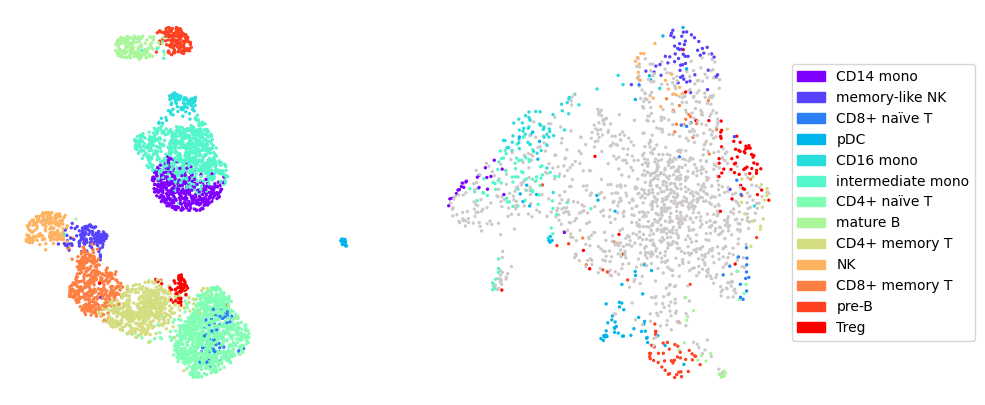

In [12]:
dim1 = 16
dim2 = 16
dim3 = 16
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 30000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]
if (with_PCA==0 or with_PPCA==0):
    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
    hyper_params = {
    'I':I,
    'J':J,
    'K':None,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': Y_tr2.mean(),  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), (X_tr2+1))
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    
    emb2 = gp_md.emb2
    embs2 = emb2((X_tr1+1)[0:J,1])
    
    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
    #sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, n_pcs=8)
    sc.pp.neighbors(RNA_struct_MOGP, n_neighbors=30, use_rep='X')
    sc.tl.umap(RNA_struct_MOGP, alpha=0.3, min_dist=.5)
    
    Acc_cells_arr=[]
    ARI_cells_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(RNA_struct_MOGP.obsm['X_umap'])
        cluster_labels = clusterer.predict(RNA_struct_MOGP.obsm['X_umap'])
        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 

    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
    sc.pp.neighbors(Genes_struct_MOGP, n_neighbors=30, n_pcs=8)
    sc.tl.umap(Genes_struct_MOGP, alpha=0.3, min_dist=.5)
    #sc.pl.umap(Genes_struct_MOGP, use_raw=False, ncols=5, size=70,)
    Acc_genes_arr=[]
    ARI_genes_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(Genes_struct_MOGP.obsm['X_umap'])
        cluster_labels_genes = clusterer.predict(Genes_struct_MOGP.obsm['X_umap'])
        train_labels_genes = np.array([col_dict1[i] for i in C1])
        Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
        ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
    
    
    print(title)
    print(np.mean(Acc_cells_arr), np.mean(ARI_cells_arr))
    print(np.mean(Acc_genes_arr), np.mean(ARI_genes_arr))  
    
    Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(rna, prot, RNA_struct_MOGP, Genes_struct_MOGP, Prot_struct_MOGP=None, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=True)
                                          
                                                
           

## BEST 2D

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:175: UserWarning: Beware, no mean function was specified in the construction of the `GPLayer` so the default `gpflow.mean_functions.Identity` is being used. This mean function will only work if the input dimensionality matches the number of latent Gaussian processes in the layer.
  warnings.warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/layers/gp_layer.py:198: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=4` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f068

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0689fe1f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0689fe1f70>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1009fe8dc0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f1009fe8af0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=100000  epochs=500  emb_reg=0.001 with_PCA=0
0.7954253405294269 0.533036477754815
0.741118800461361 0.21683682123032394


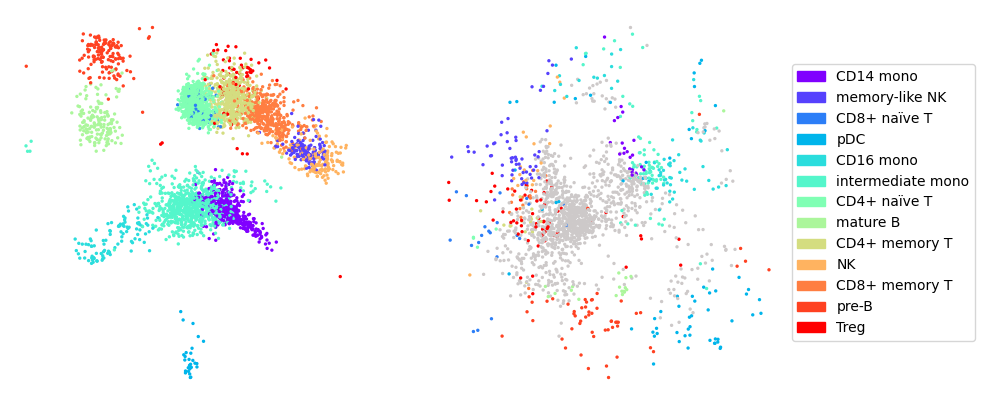

In [14]:
dim1 = 2
dim2 = 2
dim3 = 2
num_epochs = 500
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 100000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]
if (with_PCA==0 or with_PPCA==0):
    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
    hyper_params = {
    'I':I,
    'J':J,
    'K':None,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': Y_tr2.mean(),  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), (X_tr2+1))
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    
    emb2 = gp_md.emb2
    embs2 = emb2((X_tr1+1)[0:J,1])
    
    RNA_struct_MOGP = ad.AnnData(embs1.numpy())
    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()
    
    Genes_struct_MOGP = ad.AnnData(embs2.numpy())
    Genes_struct_MOGP.obsm['X_tsne']= embs2.numpy()
    
    Acc_cells_arr=[]
    ARI_cells_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(embs1)
        cluster_labels = clusterer.predict(embs1)
        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
    
    Acc_genes_arr=[]
    ARI_genes_arr=[]
    for cnt in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(embs2)
        cluster_labels_genes = clusterer.predict(embs2)
        train_labels_genes = np.array([col_dict1[i] for i in C1])
        Acc_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[0]) 
        ARI_genes_arr.append(purity_score(train_labels_genes, cluster_labels_genes)[1]) 
    
    
    
    print(title)
    print(np.mean(Acc_cells_arr), np.mean(ARI_cells_arr))
    print(np.mean(Acc_genes_arr), np.mean(ARI_genes_arr))   
    
    Relating_clusters_of_emb1_to_clusters_of_emb2_CITEseq(rna, prot, RNA_struct_MOGP, Genes_struct_MOGP, Prot_struct_MOGP=None, col_dict1=col_dict1, cell_type_list_modified1=cell_type_list_modified1, cell_type_list_modified2=cell_type_list_modified2, n_cell_types=len(list(set(rna.obs["celltype"]))),n_marker_genes=100, use_umap=False)
                                    

## BEST 8D

2024-06-09 15:09:01.608811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 15:09:02.308286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12544 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3b:00.0, compute capability: 7.5
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/gpflux/la

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f603943fa60>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f603943fa60>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f60396c65e0>
Traceback (most recent call last):
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling cty

dim1=8  dim2=8  dim3=8  InducingPoints1=512  InducingPoints2=512  BatchSize=50000  epochs=100  emb_reg=0.001 with_PCA=0
[4, 5]
0.7918272937548188 0.5449393507923636


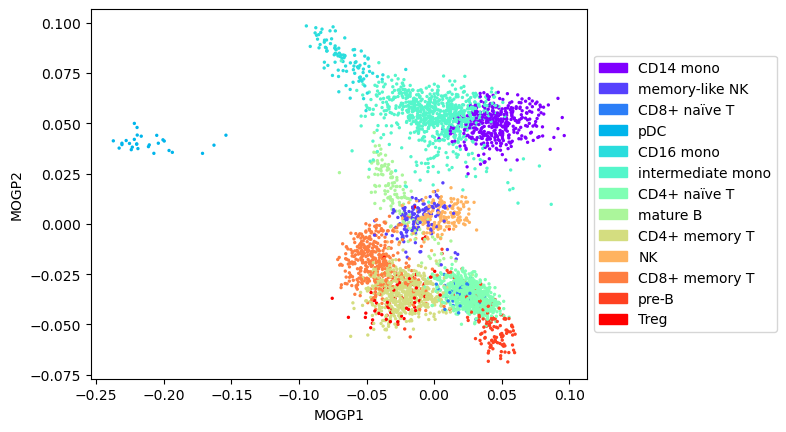

In [11]:
dim1 = 8
dim2 = 8
dim3 = 8
num_epochs = 100
n_inducing_points1 = 512
n_inducing_points2 = 512
batch_size = 50000
with_PCA = 0
with_PPCA = 0
scale_emb1 = 0
scale_emb2 = 0
emb_reg = 0.001
lr = float(0.01)
kernel = ["RBF"]
if (with_PCA==0 or with_PPCA==0):
    title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
    save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/' 
    #save_path='./PBMC5KCITEseq2View-GPFlux  dim1=2  dim2=2  dim3=2  InducingPoints1=512  InducingPoints2=512  BatchSize=10000  epochs=500  emb_reg=0.001 with_PCA=0'
    hyper_params = {
    'I':I,
    'J':J,
    'K':None,    # the number of entities in each domain
    'M1': n_inducing_points1,                  # the number of inducing pairs
    'M2': n_inducing_points2,                  # the number of inducing pairs
    'emb_sizes': [dim1,dim2,dim3],      # the embedding sizes
    'batch_size':batch_size,      # the size of training batches
    'obs_mean1': Y_tr1.mean(),  # the mean of target
    'obs_mean2': Y_tr2.mean(),  # the mean of target
    'emb_reg': emb_reg,          # l2 norm on the embeddings
    'lr': lr,                # the learning rate 
    'save_path': save_path,        # path to save the trained models.
    }  
    
    gp_md = GPD(**hyper_params)
    gp_md.build(kernels=kernel)
    gp_md.load_model((X_tr1+1), (X_tr2+1))
    
    emb1 = gp_md.emb1
    embs1 = emb1((X_tr1+1)[0:-1:J,0])
    idx1=[4,5]
    
    Acc_cells_arr=[]
    ARI_cells_arr=[]
    for i in range (10):
        clusterer = mixture.GaussianMixture(n_components=13, covariance_type='full')
        clusterer.fit(embs1.numpy()[:,idx1])
        cluster_labels = clusterer.predict(embs1.numpy()[:,idx1])
        labels=np.array([col_dict1[i] for i in rna.obs["celltype"]])
        Acc_cells_arr.append(purity_score(labels, cluster_labels)[0]) 
        ARI_cells_arr.append(purity_score(labels, cluster_labels)[1]) 
    
    
    print(title)
    print(idx1)
    print(np.mean(Acc_cells_arr), np.mean(ARI_cells_arr))
    
    RNA_struct_MOGP = ad.AnnData(embs1.numpy()[:,idx1])
    RNA_struct_MOGP.obsm['X_tsne']= embs1.numpy()[:,idx1]
    #Plot_emb1_tsne_CITEseq(rna, RNA_struct_MOGP)
    Plot_emb1_tsne(rna, RNA_struct_MOGP, col_dict1)